# COMP5318 Assignment 2: Image Classification

### Group number: 100, SID1: 490576560, SID2: 520653377 

## Setup and dependencies
All the required libraries/dependencies and the plotting environment are listed and set up here.

In [2]:
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Make the notebook's output stable across runs.
# Random seed is set to 0 consistently.
np.random.seed(0)
tf.random.set_seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)
keras.backend.clear_session()

## 1. Data loading, preprocessing, and exploration
The documentation for the data loading function can be accessed [here](https://keras.io/api/datasets/fashion_mnist/).

### 1.1 Load data and declare variables

In [3]:
# Load the Fashion-MNIST dataset training and test sets as numpy arrays
(X_train_original, y_train_original), (X_test_original, y_test_original) = keras.datasets.fashion_mnist.load_data()
assert X_train_original.shape == (60000, 28, 28)
assert X_test_original.shape == (10000, 28, 28)
assert y_train_original.shape == (60000,)
assert y_test_original.shape == (10000,)

# An ordered list of the class names
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"
              ]

# Declare size of the image
IMAGE_SIZE = X_train_original[0].shape

### 1.2 Data processing

In [4]:
# Normalise data
X_train_full = X_train_original.reshape(X_train_original.shape[0], -1) # Flatten data from 3D to 2D
y_train_full = y_train_original.copy()
X_test = X_test_original.reshape(X_test_original.shape[0], -1) # Flatten data from 3D to 2D
y_test = y_test_original.copy()

scaler = MinMaxScaler()
scaler.fit(X_train_full)
X_train_full = scaler.transform(X_train_full) # apply normalisation to the training set
X_test = scaler.transform(X_test) # apply normalisation to the test set

X_train_full = X_train_full.reshape(X_train_original.shape[0], *IMAGE_SIZE) # restore the dimention from 2D to 3D
X_test = X_test.reshape(X_test_original.shape[0], *IMAGE_SIZE) # restore the dimention from 2D to 3D

# Create validation set from the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9, stratify=y_train_full)

### 1.3 Data exploration

In [4]:
print(f"The original training set is {X_train_original.shape[0]} images with {X_train_original[0].shape} pixels, \
without normalization ({X_train_original.dtype}).")
print(f"The original test set is {X_test_original.shape[0]} images with {X_test_original[0].shape} pixels, \
without normalization ({X_test_original.dtype}).\n")

print(f"The size of training set is {X_train.shape[0]} ({X_train.dtype}), \
the size of validation set is {X_valid.shape[0]} ({X_valid.dtype}), and\
the size of test set is {X_test.shape[0]} ({X_test.dtype})")

The original training set is 60000 images with (28, 28) pixels, without normalization (uint8).
The original test set is 10000 images with (28, 28) pixels, without normalization (uint8).

The size of training set is 54000 (float64), the size of validation set is 6000 (float64), andthe size of test set is 10000 (float64)


In [5]:
def show_distribution(y):
    """Simple way to show a label distribution."""
    result = []
    for i in range(len(class_names)):
        result.append((y == i).sum())
    return result

print(f"There are {len(set(y_train_original))} different classes: {np.unique(y_train_original)}")
print(f"The label distribution of training set is {show_distribution(y_train)}")
print(f"The label distribution of validation set is {show_distribution(y_valid)}")
print(f"The label distribution of test set is {show_distribution(y_test)}")

There are 10 different classes: [0 1 2 3 4 5 6 7 8 9]
The label distribution of training set is [5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400]
The label distribution of validation set is [600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
The label distribution of test set is [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Some examples:


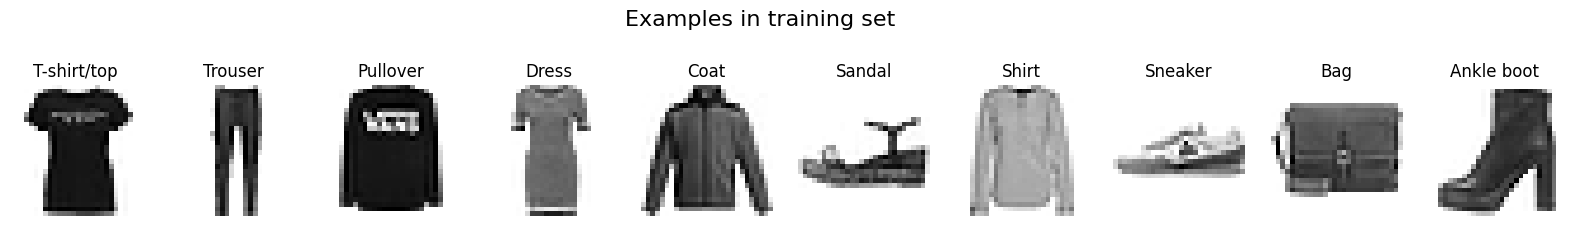

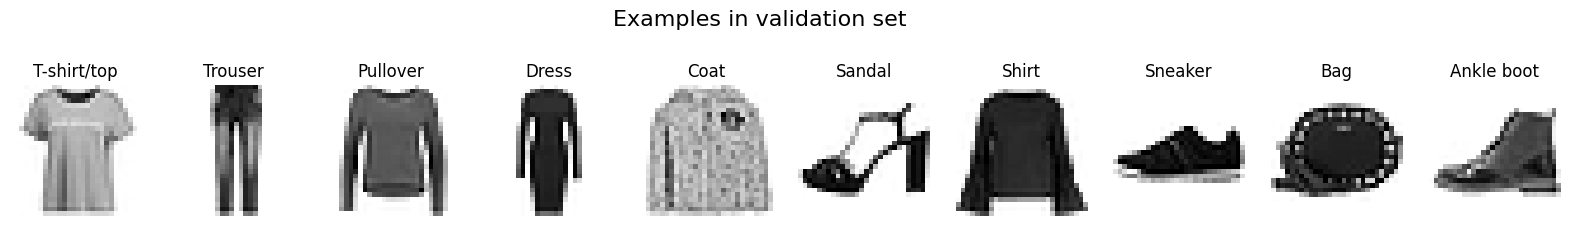

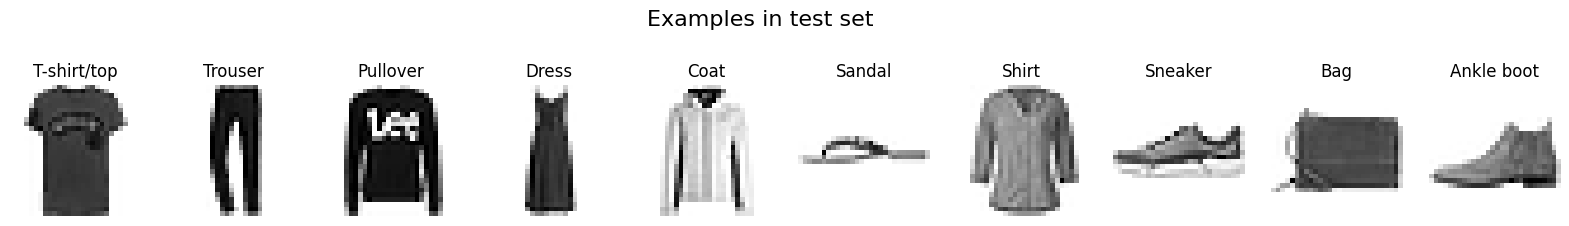

In [6]:
def plot_examples(X, y, title=""):
    """Plot a grid of images from different classes."""
    # Size figure depending on the size of the grid
    plt.figure(figsize=(20, 2))
    plt.suptitle(title, fontsize=16,x=0.5,y=1.2,)

    index = []
    # search index
    for i in range(len(class_names)):
        for j in range(len(y)):
            if i == y[j]:
                index.append(j)
                break

    # Plot the image at appropriate place in grid
    for i in range(len(index)):
        plt.subplot(1, len(index), i + 1)
        plt.imshow(X[index[i]], cmap="binary")
        plt.title(class_names[y[index[i]]])
        plt.axis('off')
            
    plt.show()

print("Some examples:")

plot_examples(X_train, y_train, "Examples in training set")
plot_examples(X_valid, y_valid, "Examples in validation set")
plot_examples(X_test, y_test, "Examples in test set")

## 2. Algorithm design and setup

### 2.1  K-nearest neighbors

First, A group of simple algorithms from the first 6 weeks are compared. They are: K-nearest neighbors, Naive Bayes, Decision tree, and Random forest. We simply train the model with default/simple parameters on the full training set, and test their accuracy.

In [7]:
neigh = KNeighborsClassifier(n_neighbors=10) # k shoule be less than sqrt(#training_examples), commercial packages typically use k=10

# Training and timer
time_stamp = time.time()
neigh.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
neigh_training_time = time.time() - time_stamp

In [8]:
nb = GaussianNB()

# Training and timer
time_stamp = time.time()
nb.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
nb_training_time = time.time() - time_stamp

In [9]:
# Running in arround 30s

tree = DecisionTreeClassifier(criterion='entropy', random_state=0) # without setting max_depth results in overfitting.

# Training and timer
time_stamp = time.time()
tree.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
tree_training_time = time.time() - time_stamp

In [10]:
# Running in arround 90s

rnd = RandomForestClassifier(criterion='entropy', random_state=0) # n_estimators=100 by default

# Training and timer
time_stamp = time.time()
rnd.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
rnd_training_time = time.time() - time_stamp

In [11]:
print(f"The accuracy of KNN is {neigh.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {neigh_training_time:.2f} s.")
print(f"The accuracy of NB is {nb.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {nb_training_time:.2f} s.")
print(f"The accuracy of DT is {tree.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {tree_training_time:.2f} s.")
print(f"The accuracy of RF is {rnd.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {rnd_training_time:.2f} s.")

The accuracy of KNN is 0.8519, training time is 0.05 s.
The accuracy of NB is 0.5838, training time is 0.64 s.
The accuracy of DT is 0.8001, training time is 29.20 s.
The accuracy of RF is 0.8760, training time is 76.81 s.


Althouth Random Forest performs best, the training time is relatively long. Noticing that KNN is simple but with a content accuracy among them, the training time is  also tiny. Therefore, KNN is chosen.

### 2.2 Fully connected neural network

First, the numbers of layers need to be settled. Apart from the **input layer** and **output layer**, the numebr of hidden layer can be a variable. According to Cybenko(1998), any function (including discontinuous) can be approximated to arbitrary small error by a network with two hidden layers. To make the model small, we choose **two hidden layers**.

Number of neurons in the input layer: 784   
For numerical attributes, basically 1 neuron per attribute, in this dataset, we have 28 * 28 = 784 atttributes each example. Thus, the number of neurons of input layer should be 784. Simply, we just use **keras.layers.Flatten(input_shape)**

Number of neurons in the output layer: 10   
1 for each class. Therefore, the number of the output layers should be 10. The **softmax** function ($\frac{e^{z_{i}}}{\sum_{j=1}^{K} e^{z_{j}}}$) converts the raw outputs of this layer into a probability distribution over the classes. 

Now we choose the hidden layers.   
**Sigmoid** is the most widely used transfer function.
We simply set most paras by default as well as the basic **SGD** learning algorithm. Since our labels are in index form rather than encoded as one-hot vectors, as we discussed earlier, we utilise the **sparse_categorical_crossentropy** loss. Then we observe the trend of the numbers of neurons with respect to MSE.

In [12]:
def test_build_mlp(num1=50, num2=50):
    """Build the MLP model with the specified number of neurons."""
    # Set Random seed to 0
    initializer = tf.keras.initializers.GlorotUniform(seed=0)
    # Define a test MLP model
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=IMAGE_SIZE),
        keras.layers.Dense(num1, activation="sigmoid", kernel_initializer=initializer),
        keras.layers.Dense(num2, activation="sigmoid", kernel_initializer=initializer),
        keras.layers.Dense(len(class_names), activation="softmax", kernel_initializer=initializer)
    ])

    opt = keras.optimizers.SGD() # default learning_rate=0.01
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

    # model.summary()
    return model

def test_train_mlp(num1, num2, max_epochs=50, criterion=0.02):
    """Training the model.
    max_epochs: the maximum number of epochs to terminate.
    criterion: stop when the difference between the loss of the last 5 epoch is less than."""
    # Train the classifier.
    mlp = test_build_mlp(num1, num2)
    loss_list = []
    for i in range(max_epochs):
        history = mlp.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=1)
        loss_list.append(history.history["loss"][0])

        # Stop condition
        if len(loss_list) > 5 and loss_list[-6] - loss_list[-1] < criterion:
            print(len(loss_list))
            break
    
    return loss_list[-1], len(loss_list)

In [13]:
# Running in arround 960s

# some possible numbers to choose
hidden_layer_1 = [100, 200, 300, 400, 500, 600]

# results
loss_history_1 = []
epoch_history_1 = []

# for the first hidden layer
for i in hidden_layer_1:
    loss, epoch = test_train_mlp(i, 50)
    loss_history_1.append(loss)
    epoch_history_1.append(epoch)

1688/1688 [==============================] - 2s 1ms/step - loss: 0.4207 - accuracy: 0.8515 - val_loss: 0.4231 - val_accuracy: 0.8475
33
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4352 - accuracy: 0.8459 - val_loss: 0.4365 - val_accuracy: 0.8408
29
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4354 - accuracy: 0.8462 - val_loss: 0.4405 - val_accuracy: 0.8412
29
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4388 - accuracy: 0.8455 - val_loss: 0.4401 - val_accuracy: 0.8420
27
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4387 - accuracy: 0.8453 - val_loss: 0.4443 - val_accuracy: 0.8397
28
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4382 - accuracy: 0.8456 - val_loss: 0.4399 - val_accuracy: 0.8412
27


In [14]:
loss_history_1 = [round(i, 4) for i in loss_history_1]
print(f"The min loss is {min(loss_history_1)} when neurons is equal to {hidden_layer_1[loss_history_1.index(min(loss_history_1))]}")

print(f"Loss history: {loss_history_1}")
print(f"Epoch history: {epoch_history_1}")

The min loss is 0.4207 when neurons is equal to 100
Loss history: [0.4207, 0.4352, 0.4354, 0.4388, 0.4387, 0.4382]
Epoch history: [33, 29, 29, 27, 28, 27]


It shows that when the number of neurons of the first layer is 100, the loss is minimal. Although the epochs is slightly larger, which may enhance the performance, the training time is much faster because of the lesser neurons. To keep the model small, we choose the 100 as the first number of neurons of the hidden layers.

In [15]:
# Running in arround 340s

# some possible numbers to choose
hidden_layer_2 = [20, 40, 60, 80]

# results
loss_history_2 = []
epoch_history_2 = []

# for the first hidden layer
for i in hidden_layer_2:
    loss, epoch = test_train_mlp(100, i)
    loss_history_2.append(loss)
    epoch_history_2.append(epoch)

1688/1688 [==============================] - 2s 1ms/step - loss: 0.4282 - accuracy: 0.8496 - val_loss: 0.4310 - val_accuracy: 0.8438
34
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4221 - accuracy: 0.8513 - val_loss: 0.4277 - val_accuracy: 0.8458
32
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4274 - accuracy: 0.8496 - val_loss: 0.4316 - val_accuracy: 0.8438
31
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4253 - accuracy: 0.8495 - val_loss: 0.4296 - val_accuracy: 0.8428
31


In [16]:
loss_history_2 = [round(i, 4) for i in loss_history_2]
print(f"The min loss is {min(loss_history_2)} when neurons is equal to {hidden_layer_2[loss_history_2.index(min(loss_history_2))]}")

print(f"Loss history: {loss_history_2}")
print(f"Epoch history: {epoch_history_2}")

The min loss is 0.4221 when neurons is equal to 40
Loss history: [0.4282, 0.4221, 0.4274, 0.4253]
Epoch history: [34, 32, 31, 31]


We select 20 as the neurons of the second hidden layer using the same method as before consistently. 

### 2.3 Convolutional neural network

The architecture of CNN is settled in this section.   

The input shape shoule be (28, 28, 1). This last dimension indicates the channel. The dataset consists of grey images, thus, the channel is 1. Although usually the CNN performs well, the theory of determining the architecture, such as the number of convolutional layers, the number of filters, is unclear. Sometimes it is determined by experiment and experience. Given that the condition is limited, we just choose the similar architecture from the tutorial. In other words, we choose two conv and pool blocks with 32, 64 (empirically it should be exponentiation of 2) filters respectively, follower by a simple FC layer.   

We also choose Max Pooling due to the distribution of pixels each image (features are presented as large value of pixels).   

We have discussed the ReLU and Softmax previously.

The drouout layer is added to avoid overfitting.

The rest paras such as filter size, strides, and learning rate, will be tuned in section 3.3.

In [17]:
keras.Sequential([
    # Specify the input shape
    keras.Input(shape=(*IMAGE_SIZE, 1)),
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", strides=(1, 1), kernel_initializer=initializer),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
    
    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", strides=(1, 1), kernel_initializer=initializer),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
    
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax", kernel_initializer=initializer),
])

## 3. Hyperparameter tuning

In [18]:
# Helper method in this section.
def get_result(estimator, paras, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=1):
    """get grid search result.
    estimator: model to be tuned.
    paras: an instance of ParameterGrid."""
    # Return a dict
    result = {
        "best_paras": None,
        "best_score": 0,
        "best_estimator": None,
        "results": [],
    }

    i = 0

    # Grid search for each combination.
    for para in paras:
        # Set para
        current_estimator = clone(estimator)
        current_estimator.set_params(**para)

        # Training and timer
        t1 = time.time()
        if epochs == 1:
            current_estimator.fit(X_train, y_train)
        else:
            current_estimator.fit(X_train, y_train, epochs=epochs)
        t2 = time.time()

        # Score on validation set
        score = current_estimator.score(X_valid, y_valid)
        t3 = time.time()

        # result for each combination
        temp = {}
        temp["paras"] = para
        temp["training_time"] = t2 - t1
        temp["validation_time"] = t3 - t2
        temp["score"] =score
        
        # Update the best result
        result["results"].append(temp)
        if score > result["best_score"]:
            result["best_paras"] = para
            result["best_score"] = score
            result["best_estimator"] = current_estimator
        
        i += 1
        print(f"{i} out of {len(list(paras))} finished: {para}")

    return result

def show_results(name, result, X_test=X_test, y_test=y_test):
    """Show the results."""
    print(f"Results for {name}:")
    print("Best parameters: {}".format(result["best_paras"]))
    print("Best validation score: {:.4f}".format(result["best_score"]))
    print("Test set score: {:.4f}".format(result["best_estimator"].score(X_test, y_test)))

    # table of results
    df = pd.DataFrame(
        columns=["Score", "training_time", "validation_time"], 
        index=[str(result["results"][i]["paras"]) for i in range(len(result["results"]))]
        )

    for i in range(len(result["results"])):
        df.loc[str(result["results"][i]["paras"])] = [
            round(result["results"][i]["score"], 4),
            round(result["results"][i]["training_time"], 2),
            round(result["results"][i]["validation_time"], 2)
            ]

    df.to_csv(f'{name}_results.csv')
    display(df)

### 3.1 K-nearest neighbors

First, to determine a rough trend of the accuracy with different k, we calculate an accuracy every 10 with different k, until k = 245 (sqrt(#examples)), e.g., k = [1, 11, 21, ..., 241]

In [19]:
# Running in arroung 190s

k_value = [1 + i for i in range(245)]
k_acc = []

for i in k_value:
    if i % 10 != 1:
        continue
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
    k_acc.append(knn.score(X_test.reshape(X_test.shape[0], -1), y_test))
    print(f"k = {i}\t finished.")

k = 1	 finished.
k = 11	 finished.
k = 21	 finished.
k = 31	 finished.
k = 41	 finished.
k = 51	 finished.
k = 61	 finished.
k = 71	 finished.
k = 81	 finished.
k = 91	 finished.
k = 101	 finished.
k = 111	 finished.
k = 121	 finished.
k = 131	 finished.
k = 141	 finished.
k = 151	 finished.
k = 161	 finished.
k = 171	 finished.
k = 181	 finished.
k = 191	 finished.
k = 201	 finished.
k = 211	 finished.
k = 221	 finished.
k = 231	 finished.
k = 241	 finished.


<Figure size 200x200 with 0 Axes>

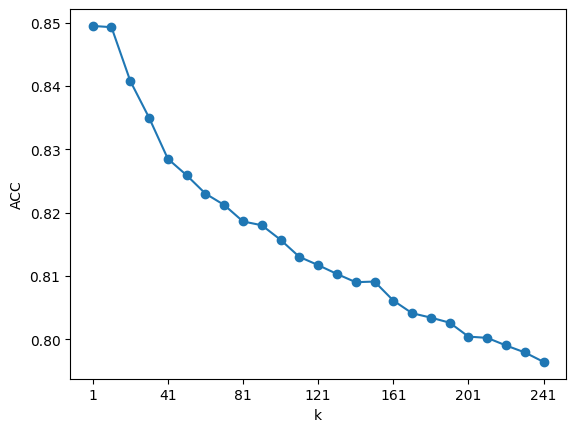

In [20]:
plt.figure(figsize=(2, 2))
fig, ax = plt.subplots()

ax.plot([i*10 + 1 for i in range(25)], k_acc, marker="o")
ax.set(xlabel="k", ylabel="ACC", xticks=range(1, 250, 40))
plt.show()

From the figure, the trend is roughly decending. Therefore, we can choose a range of k in [1, 21]

In [21]:
# Running in arroung 140s

k_value = [i for i in range(1,21)]
k_acc = []

for i in k_value:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
    k_acc.append(knn.score(X_test.reshape(X_test.shape[0], -1), y_test))
    print(f"k = {i}\t finished.")

k = 1	 finished.
k = 2	 finished.
k = 3	 finished.
k = 4	 finished.
k = 5	 finished.
k = 6	 finished.
k = 7	 finished.
k = 8	 finished.
k = 9	 finished.
k = 10	 finished.
k = 11	 finished.
k = 12	 finished.
k = 13	 finished.
k = 14	 finished.
k = 15	 finished.
k = 16	 finished.
k = 17	 finished.
k = 18	 finished.
k = 19	 finished.
k = 20	 finished.


<Figure size 200x200 with 0 Axes>

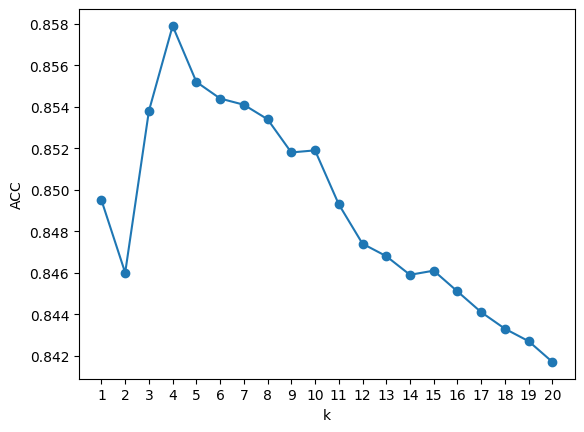

In [22]:
plt.figure(figsize=(2, 2))
fig, ax = plt.subplots()

ax.plot(k_value, k_acc, marker="o")
ax.set(xlabel="k", ylabel="ACC", xticks=k_value)
plt.show()

From the figure above, we chose k = [3, 5, 9]. For p, we chose p [1, 2], it represents manhattan_distance and euclidean_distance respectively. We also consider the weight (uniform, distance) each point contribute to.

If we use CV with 10 folds, totally we need 3 * 2 * 2 * cv = 120 on 90% training set. Considering the running time, we use standard grid search instead.

In [23]:
# Setting parameters
param_grid = {
    'n_neighbors': [3, 5, 9],
    'p': [1, 2],
    "weights": ["uniform", "distance"],
    }

knn_paras = ParameterGrid(param_grid)

print(f"There are {len(list(knn_paras))} combinations.")
print("Parameter grid:\n{}".format(param_grid))

# ----------------------------------------------------------
# CV for tuning
# Setting the 10 fold stratified cross-validation

# cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cvKFold, return_train_score=True, verbose=3)
# grid_search.fit(X_train_full.reshape(60000, -1), y_train_full)

There are 12 combinations.
Parameter grid:
{'n_neighbors': [3, 5, 9], 'p': [1, 2], 'weights': ['uniform', 'distance']}


In [24]:
# Running in around 410s

# Tuning KNN paras, 12 combination in total.
knn_result = get_result(
    KNeighborsClassifier(), 
    knn_paras, 
    X_train=X_train.reshape(X_train.shape[0], -1), 
    X_valid=X_valid.reshape(X_valid.shape[0], -1)
    )

1 out of 12 finished: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
2 out of 12 finished: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
3 out of 12 finished: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
4 out of 12 finished: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
5 out of 12 finished: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
6 out of 12 finished: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
7 out of 12 finished: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
8 out of 12 finished: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
9 out of 12 finished: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
10 out of 12 finished: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
11 out of 12 finished: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
12 out of 12 finished: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}


In [25]:
# Running in around 110s

show_results("KNN", knn_result, X_test=X_test.reshape(X_test.shape[0], -1))

Results for KNN:
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best validation score: 0.8653
Test set score: 0.8567


,Score,training_time,validation_time
"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.8622,0.05,39.26
"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",0.8653,0.04,39.2
"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.8583,0.05,2.23
"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.8602,0.04,2.11
"{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}",0.8603,0.05,39.21
"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.8622,0.04,39.0
"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.855,0.05,2.25
"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.8577,0.04,2.1
"{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}",0.8628,0.05,39.25
"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",0.8645,0.04,39.12


### 3.2 Fully connected neural network

From section 2.2, we settled the numbers of neurons (100, 20) in hidden layers. Although the number of hidden layers as well as number of neurons are also hyperparameter, to avoid a great running time due to a number of combination of paras, we design the structure first and tune the other paras in this section.

In [26]:
def build_mlp(activation_function="relu"):
    """Build a Keras MLP for 10 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    
    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=IMAGE_SIZE))
    
    # Add the hidden layers with activation function
    model.add(keras.layers.Dense(100, activation=activation_function, kernel_initializer=initializer))
    model.add(keras.layers.Dense(20, activation=activation_function, kernel_initializer=initializer))
        
    # Add the output layer for 10 class classification
    model.add(keras.layers.Dense(10, activation="softmax", kernel_initializer=initializer))
    
    return model

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier = KerasClassifier(build_mlp,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__lr=0.01,
                                   metrics=["accuracy"]
                                  )

param_grid = {
    "optimizer__lr": [0.1, 0.01, 0.001],
    "activation_function": ["relu", "sigmoid", "tanh", None],
    "optimizer": ["sgd", "Adam"]
}

mlp_paras = ParameterGrid(param_grid)

print(f"There are {len(list(mlp_paras))} combinations.")
print("Parameter grid:\n{}".format(param_grid))

There are 24 combinations.
Parameter grid:
{'optimizer__lr': [0.1, 0.01, 0.001], 'activation_function': ['relu', 'sigmoid', 'tanh', None], 'optimizer': ['sgd', 'Adam']}


In [27]:
# Running in arround 1800s

mlp_result = get_result(keras_classifier, mlp_paras, epochs=30)

Epoch 1/30


C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5692 - accuracy: 0.7940
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4100 - accuracy: 0.8495
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3694 - accuracy: 0.8652
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3462 - accuracy: 0.8723
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3276 - accuracy: 0.8797
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3121 - accuracy: 0.8850
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2997 - accuracy: 0.8892
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2893 - accuracy: 0.8914
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2805 - accuracy: 0.8959
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2765 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.8046 - accuracy: 0.7284
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5149 - accuracy: 0.8220
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4636 - accuracy: 0.8389
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4366 - accuracy: 0.8459
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4167 - accuracy: 0.8546
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4010 - accuracy: 0.8614
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3878 - accuracy: 0.8636
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3767 - accuracy: 0.8686
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3669 - accuracy: 0.8704
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3579 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.7509 - accuracy: 0.4678
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0714 - accuracy: 0.6799
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8289 - accuracy: 0.7346
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7273 - accuracy: 0.7632
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6682 - accuracy: 0.7811
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6274 - accuracy: 0.7928
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5974 - accuracy: 0.8031
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5739 - accuracy: 0.8099
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5551 - accuracy: 0.8155
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5398 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 2.3889 - accuracy: 0.0987
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.3145 - accuracy: 0.1024
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.3160 - accuracy: 0.0994
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.3151 - accuracy: 0.1019
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.3154 - accuracy: 0.0998
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.3156 - accuracy: 0.0992
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.3150 - accuracy: 0.0994
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.3161 - accuracy: 0.1004
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.3157 - accuracy: 0.0989
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.3153 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5658 - accuracy: 0.7964
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4404 - accuracy: 0.8429
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4153 - accuracy: 0.8515
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4080 - accuracy: 0.8550
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3936 - accuracy: 0.8603
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3867 - accuracy: 0.8628
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3772 - accuracy: 0.8668
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3699 - accuracy: 0.8680
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3672 - accuracy: 0.8669
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3628 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5611 - accuracy: 0.8071
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3969 - accuracy: 0.8580
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3529 - accuracy: 0.8721
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3290 - accuracy: 0.8808
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3090 - accuracy: 0.8864
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2976 - accuracy: 0.8902
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2818 - accuracy: 0.8951
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2700 - accuracy: 0.8994
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2627 - accuracy: 0.9022
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2550 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.0289 - accuracy: 0.6634
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5646 - accuracy: 0.8033
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4822 - accuracy: 0.8307
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4410 - accuracy: 0.8434
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4164 - accuracy: 0.8521
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3986 - accuracy: 0.8587
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3843 - accuracy: 0.8624
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3732 - accuracy: 0.8660
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3628 - accuracy: 0.8701
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3540 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 2.1381 - accuracy: 0.3653
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.6040 - accuracy: 0.5187
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2435 - accuracy: 0.6092
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0481 - accuracy: 0.6567
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.9208 - accuracy: 0.6959
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8279 - accuracy: 0.7254
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7591 - accuracy: 0.7432
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7082 - accuracy: 0.7550
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6698 - accuracy: 0.7633
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6401 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 2.3492 - accuracy: 0.0999
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2777 - accuracy: 0.1546
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2488 - accuracy: 0.3378
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2198 - accuracy: 0.3964
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.1865 - accuracy: 0.4090
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.1480 - accuracy: 0.4098
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.1030 - accuracy: 0.4263
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.0511 - accuracy: 0.4282
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.9924 - accuracy: 0.4365
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.9284 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.6874 - accuracy: 0.2710
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4965 - accuracy: 0.3416
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4175 - accuracy: 0.3722
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4443 - accuracy: 0.3606
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4162 - accuracy: 0.3785
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4231 - accuracy: 0.3663
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4763 - accuracy: 0.3491
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5177 - accuracy: 0.3306
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5076 - accuracy: 0.3293
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4727 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5802 - accuracy: 0.7957
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4825 - accuracy: 0.8266
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4550 - accuracy: 0.8361
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4402 - accuracy: 0.8452
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4344 - accuracy: 0.8458
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4249 - accuracy: 0.8486
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4178 - accuracy: 0.8510
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4152 - accuracy: 0.8519
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4121 - accuracy: 0.8536
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4055 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.7973 - accuracy: 0.7555
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4302 - accuracy: 0.8519
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3747 - accuracy: 0.8664
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3452 - accuracy: 0.8759
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3241 - accuracy: 0.8831
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3088 - accuracy: 0.8874
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2948 - accuracy: 0.8931
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2829 - accuracy: 0.8976
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2722 - accuracy: 0.9001
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2644 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5454 - accuracy: 0.8034
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4117 - accuracy: 0.8519
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3738 - accuracy: 0.8633
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3489 - accuracy: 0.8724
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3324 - accuracy: 0.8787
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3190 - accuracy: 0.8832
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3050 - accuracy: 0.8883
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2962 - accuracy: 0.8910
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2861 - accuracy: 0.8956
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2794 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.8266 - accuracy: 0.7339
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5319 - accuracy: 0.8216
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4694 - accuracy: 0.8375
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4379 - accuracy: 0.8451
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4170 - accuracy: 0.8531
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4010 - accuracy: 0.8578
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3881 - accuracy: 0.8628
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3776 - accuracy: 0.8652
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3687 - accuracy: 0.8689
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3608 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.5609 - accuracy: 0.5014
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0839 - accuracy: 0.6846
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.9162 - accuracy: 0.7250
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8202 - accuracy: 0.7500
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7550 - accuracy: 0.7681
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7064 - accuracy: 0.7806
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6684 - accuracy: 0.7905
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6376 - accuracy: 0.7977
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6122 - accuracy: 0.8038
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5911 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 2.0410 - accuracy: 0.2114
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5137 - accuracy: 0.0997
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5218 - accuracy: 0.1020
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5092 - accuracy: 0.0980
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5055 - accuracy: 0.1016
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5138 - accuracy: 0.0988
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5012 - accuracy: 0.1010
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5144 - accuracy: 0.1001
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5145 - accuracy: 0.0997
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.5078 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.6999 - accuracy: 0.7386
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6586 - accuracy: 0.7600
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6399 - accuracy: 0.7658
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6190 - accuracy: 0.7800
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6094 - accuracy: 0.7826
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6163 - accuracy: 0.7823
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6113 - accuracy: 0.7838
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5815 - accuracy: 0.7983
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5760 - accuracy: 0.8020
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5888 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5282 - accuracy: 0.8187
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3861 - accuracy: 0.8617
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3496 - accuracy: 0.8725
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3268 - accuracy: 0.8804
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3076 - accuracy: 0.8877
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2961 - accuracy: 0.8914
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2833 - accuracy: 0.8943
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2710 - accuracy: 0.8996
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2637 - accuracy: 0.9028
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2565 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.6151 - accuracy: 0.7898
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4874 - accuracy: 0.8287
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4661 - accuracy: 0.8369
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4559 - accuracy: 0.8395
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4471 - accuracy: 0.8431
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4410 - accuracy: 0.8467
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4353 - accuracy: 0.8479
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4337 - accuracy: 0.8481
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4286 - accuracy: 0.8498
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4274 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.6869 - accuracy: 0.7695
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5029 - accuracy: 0.8253
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4684 - accuracy: 0.8370
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4517 - accuracy: 0.8414
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4400 - accuracy: 0.8483
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4315 - accuracy: 0.8514
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4255 - accuracy: 0.8528
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4208 - accuracy: 0.8535
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4163 - accuracy: 0.8551
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4132 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.2267 - accuracy: 0.6091
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7741 - accuracy: 0.7459
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6720 - accuracy: 0.7808
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6184 - accuracy: 0.7976
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5844 - accuracy: 0.8076
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5604 - accuracy: 0.8142
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5427 - accuracy: 0.8188
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5286 - accuracy: 0.8211
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5175 - accuracy: 0.8242
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5083 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 5.3032 - accuracy: 0.7281
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 312.9030 - accuracy: 0.7216
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 8.3640 - accuracy: 0.7509
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 4.8701 - accuracy: 0.7429
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 436.6196 - accuracy: 0.7366
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 96.9422 - accuracy: 0.7536
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 18.1001 - accuracy: 0.7565
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 10.5929 - accuracy: 0.7430
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 371.4419 - accuracy: 0.7241
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 24.0935

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.6689 - accuracy: 0.7812
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5822 - accuracy: 0.8036
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5668 - accuracy: 0.8093
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5472 - accuracy: 0.8158
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5577 - accuracy: 0.8166
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5435 - accuracy: 0.8179
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5316 - accuracy: 0.8234
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5391 - accuracy: 0.8226
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5307 - accuracy: 0.8233
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5297 - accurac

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5468 - accuracy: 0.8079
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4629 - accuracy: 0.8384
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4449 - accuracy: 0.8452
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4354 - accuracy: 0.8476
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4292 - accuracy: 0.8504
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4218 - accuracy: 0.8528
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4177 - accuracy: 0.8529
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4107 - accuracy: 0.8564
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4086 - accuracy: 0.8558
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4087 - accurac

In [28]:
show_results("MLP", mlp_result)

Results for MLP:
Best parameters: {'activation_function': 'sigmoid', 'optimizer': 'Adam', 'optimizer__lr': 0.001}
Best validation score: 0.8955
313/313 [==============================] - 0s 814us/step
Test set score: 0.8850


,Score,training_time,validation_time
"{'activation_function': 'relu', 'optimizer': 'sgd', 'optimizer__lr': 0.1}",0.8633,58.39,0.34
"{'activation_function': 'relu', 'optimizer': 'sgd', 'optimizer__lr': 0.01}",0.8825,57.18,0.29
"{'activation_function': 'relu', 'optimizer': 'sgd', 'optimizer__lr': 0.001}",0.847,57.33,0.29
"{'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.1}",0.1,59.89,0.3
"{'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.01}",0.8635,59.86,0.3
"{'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.001}",0.893,59.71,0.3
"{'activation_function': 'sigmoid', 'optimizer': 'sgd', 'optimizer__lr': 0.1}",0.8877,57.96,0.33
"{'activation_function': 'sigmoid', 'optimizer': 'sgd', 'optimizer__lr': 0.01}",0.8468,57.99,0.3
"{'activation_function': 'sigmoid', 'optimizer': 'sgd', 'optimizer__lr': 0.001}",0.6398,57.42,0.3
"{'activation_function': 'sigmoid', 'optimizer': 'Adam', 'optimizer__lr': 0.1}",0.1,59.94,0.3


From the table above, both {'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.001} and {'activation_function': 'sigmoid', 'optimizer': 'Adam', 'optimizer__lr': 0.001} are good. Considering the limitations of Sigmoid activation function, we choose **ReLU** in this study.

Then we observe the trend of epochs with these paras.

In [29]:
# build a model with paras we just chose
mlp_model = build_mlp(activation_function="relu")

mlp_model.summary()

mlp_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_35 (Flatten)        (None, 784)               0         
                                                                 
 dense_103 (Dense)           (None, 100)               78500     
                                                                 
 dense_104 (Dense)           (None, 20)                2020      
                                                                 
 dense_105 (Dense)           (None, 10)                210       
                                                                 
Total params: 80,730
Trainable params: 80,730
Non-trainable params: 0
_________________________________________________________________


In [30]:
mlp_history = mlp_model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5352 - accuracy: 0.8121 - val_loss: 0.4039 - val_accuracy: 0.8525
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3900 - accuracy: 0.8595 - val_loss: 0.3651 - val_accuracy: 0.8673
Epoch 3/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3486 - accuracy: 0.8740 - val_loss: 0.3656 - val_accuracy: 0.8667
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3273 - accuracy: 0.8799 - val_loss: 0.3249 - val_accuracy: 0.8802
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3083 - accuracy: 0.8867 - val_loss: 0.3201 - val_accuracy: 0.8815
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2945 - accuracy: 0.8913 - val_loss: 0.3273 - val_accuracy: 0.8827
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2806 - accuracy: 0.8970 - val_loss: 0.3187 - val_accuracy:

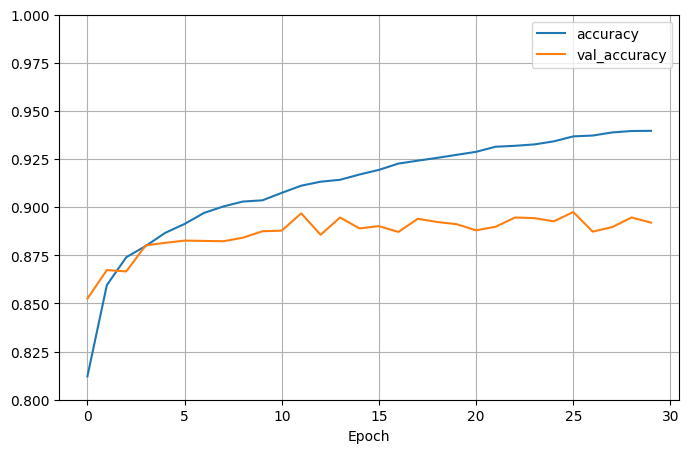

In [31]:
# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

The accuracy of validation set fluctuated since epoch = 10, thus, we set the epochs = 10 to keep it small.

### 3.3 Convolutional neural network

In section 2.2, we fixed a set ot paras as well as the architecture of CNN.

In [32]:
def build_cnn(kernel_size=(3, 3), strides=(1, 1), activation_function="relu"):
    """Build a Keras CNN for 10 class classification with desired parameters."""
    
    model = keras.Sequential([
        # Specify the input shape
        keras.Input(shape=(*IMAGE_SIZE, 1)),
        
        # Conv and pool block 1
        keras.layers.Conv2D(
            32, 
            kernel_size=kernel_size, 
            activation=activation_function, 
            strides=strides,
            kernel_initializer=initializer
            ),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
        
        # Conv and pool block 2
        keras.layers.Conv2D(
            64, 
            kernel_size=kernel_size, 
            activation=activation_function, 
            strides=strides,
            kernel_initializer=initializer
            ),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
        
        # Flatten and classify using dense output layer
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(class_names), activation="softmax", kernel_initializer=initializer),
    ])
    
    return model

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_cnn if we wish to tune them
keras_classifier = KerasClassifier(build_cnn,
                                   kernel_size=(3, 3),
                                   strides=(1, 1),
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="adam",
                                   optimizer__lr=0.01,
                                   metrics=["accuracy"]
                                  )

# For an odd-sized filter, all the previous layer pixels would be symmetrical around the output pixel.
param_grid = {
    "optimizer__lr": [0.01, 0.005, 0.001],
    "kernel_size": [(3, 3), (5, 5)],
    "strides": [(1, 1), (2, 2)]
}

cnn_paras = ParameterGrid(param_grid)

print(f"There are {len(list(cnn_paras))} combinations.")
print("Parameter grid:\n{}".format(param_grid))

There are 12 combinations.
Parameter grid:
{'optimizer__lr': [0.01, 0.005, 0.001], 'kernel_size': [(3, 3), (5, 5)], 'strides': [(1, 1), (2, 2)]}


In [33]:
# Running in arround 1100s

cnn_result = get_result(
    keras_classifier, 
    cnn_paras,
    X_train=np.expand_dims(X_train, -1),
    X_valid=np.expand_dims(X_valid, -1), 
    epochs=10
    )

Epoch 1/10


C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 14s 8ms/step - loss: 0.5106 - accuracy: 0.8159
Epoch 2/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.4297 - accuracy: 0.8457
Epoch 3/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.4125 - accuracy: 0.8499
Epoch 4/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4079 - accuracy: 0.8516
Epoch 5/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4052 - accuracy: 0.8518
Epoch 6/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4009 - accuracy: 0.8524
Epoch 7/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3999 - accuracy: 0.8525
Epoch 8/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4023 - accuracy: 0.8536
Epoch 9/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3979 - accuracy: 0.8545
Epoch 10/10
188/188 [==============================] - 0s 2ms/step
1 out of 12 finis

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 4s 2ms/step - loss: 0.6464 - accuracy: 0.7607
Epoch 2/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5246 - accuracy: 0.8076
Epoch 3/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5122 - accuracy: 0.8132
Epoch 4/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5041 - accuracy: 0.8164
Epoch 5/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4974 - accuracy: 0.8183
Epoch 6/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4967 - accuracy: 0.8186
Epoch 7/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4898 - accuracy: 0.8206
Epoch 8/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4873 - accuracy: 0.8229
Epoch 9/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4809 - accuracy: 0.8234
Epoch 10/10
188/188 [==============================] - 0s 1ms/step
2 out of 12 finished: {'ke

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 13s 8ms/step - loss: 0.4793 - accuracy: 0.8269
Epoch 2/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3706 - accuracy: 0.8672
Epoch 3/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3514 - accuracy: 0.8713
Epoch 4/10
1688/1688 [==============================] - 13s 7ms/step - loss: 0.3392 - accuracy: 0.8758
Epoch 5/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3326 - accuracy: 0.8781
Epoch 6/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3287 - accuracy: 0.8796
Epoch 7/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3226 - accuracy: 0.8837
Epoch 8/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3201 - accuracy: 0.8849
Epoch 9/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.3143 - accuracy: 0.8847
Epoch 10/10
188/188 [==============================] - 0s 2ms/step
3 out of 12 finis

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 4s 2ms/step - loss: 0.6127 - accuracy: 0.7793
Epoch 2/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4696 - accuracy: 0.8312
Epoch 3/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4392 - accuracy: 0.8393
Epoch 4/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4255 - accuracy: 0.8443
Epoch 5/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4132 - accuracy: 0.8506
Epoch 6/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4000 - accuracy: 0.8538
Epoch 7/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3986 - accuracy: 0.8560
Epoch 8/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3921 - accuracy: 0.8564
Epoch 9/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3903 - accuracy: 0.8555
Epoch 10/10
188/188 [==============================] - 0s 1ms/step
4 out of 12 finished: {'ke

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 13s 8ms/step - loss: 0.5375 - accuracy: 0.8042
Epoch 2/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3787 - accuracy: 0.8653
Epoch 3/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3361 - accuracy: 0.8788
Epoch 4/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3051 - accuracy: 0.8901
Epoch 5/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2880 - accuracy: 0.8951
Epoch 6/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2745 - accuracy: 0.8992
Epoch 7/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2660 - accuracy: 0.9031
Epoch 8/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2541 - accuracy: 0.9080
Epoch 9/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2465 - accuracy: 0.9095
Epoch 10/10
188/188 [==============================] - 1s 2ms/step
5 out of 12 finis

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 5s 3ms/step - loss: 0.7582 - accuracy: 0.7272
Epoch 2/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5165 - accuracy: 0.8155
Epoch 3/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4611 - accuracy: 0.8351
Epoch 4/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4282 - accuracy: 0.8451
Epoch 5/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4098 - accuracy: 0.8527
Epoch 6/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3953 - accuracy: 0.8568
Epoch 7/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3815 - accuracy: 0.8631
Epoch 8/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3760 - accuracy: 0.8652
Epoch 9/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3664 - accuracy: 0.8667
Epoch 10/10
188/188 [==============================] - 0s 1ms/step
6 out of 12 finished: {'ke

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 15s 9ms/step - loss: 0.5695 - accuracy: 0.7952
Epoch 2/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4951 - accuracy: 0.8181
Epoch 3/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4858 - accuracy: 0.8224
Epoch 4/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4815 - accuracy: 0.8237
Epoch 5/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4773 - accuracy: 0.8244
Epoch 6/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4692 - accuracy: 0.8270
Epoch 7/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4695 - accuracy: 0.8273
Epoch 8/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4648 - accuracy: 0.8284
Epoch 9/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4678 - accuracy: 0.8289
Epoch 10/10
188/188 [==============================] - 1s 2ms/step
7 out of 12 finis

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 6s 3ms/step - loss: 0.6917 - accuracy: 0.7457
Epoch 2/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5858 - accuracy: 0.7834
Epoch 3/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5608 - accuracy: 0.7908
Epoch 4/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5455 - accuracy: 0.7950
Epoch 5/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5459 - accuracy: 0.7950
Epoch 6/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5392 - accuracy: 0.7988
Epoch 7/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5345 - accuracy: 0.7986
Epoch 8/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5327 - accuracy: 0.8011
Epoch 9/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5256 - accuracy: 0.8049
Epoch 10/10
188/188 [==============================] - 0s 2ms/step
8 out of 12 finished: {'ke

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 16s 9ms/step - loss: 0.5255 - accuracy: 0.8096
Epoch 2/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4117 - accuracy: 0.8522
Epoch 3/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.3926 - accuracy: 0.8586
Epoch 4/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3733 - accuracy: 0.8678
Epoch 5/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3692 - accuracy: 0.8642
Epoch 6/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3655 - accuracy: 0.8652
Epoch 7/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3579 - accuracy: 0.8686
Epoch 8/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3602 - accuracy: 0.8674
Epoch 9/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3559 - accuracy: 0.8694
Epoch 10/10
188/188 [==============================] - 0s 2ms/step
9 out of 12 finis

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 5s 3ms/step - loss: 0.6481 - accuracy: 0.7616
Epoch 2/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5135 - accuracy: 0.8091
Epoch 3/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4851 - accuracy: 0.8213
Epoch 4/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4695 - accuracy: 0.8253
Epoch 5/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4582 - accuracy: 0.8293
Epoch 6/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4495 - accuracy: 0.8305
Epoch 7/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4428 - accuracy: 0.8319
Epoch 8/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4344 - accuracy: 0.8357
Epoch 9/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4343 - accuracy: 0.8350
Epoch 10/10
188/188 [==============================] - 0s 1ms/step
10 out of 12 finished: {'k

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 16s 9ms/step - loss: 0.5776 - accuracy: 0.7898
Epoch 2/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3956 - accuracy: 0.8571
Epoch 3/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3523 - accuracy: 0.8732
Epoch 4/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3286 - accuracy: 0.8814
Epoch 5/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3100 - accuracy: 0.8878
Epoch 6/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2958 - accuracy: 0.8924
Epoch 7/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2811 - accuracy: 0.8971
Epoch 8/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2738 - accuracy: 0.9014
Epoch 9/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2660 - accuracy: 0.9007
Epoch 10/10
188/188 [==============================] - 0s 2ms/step
11 out of 12 fini

C:\Users\zzha9494\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 5s 3ms/step - loss: 0.7471 - accuracy: 0.7314
Epoch 2/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5564 - accuracy: 0.7992
Epoch 3/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5024 - accuracy: 0.8184
Epoch 4/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4737 - accuracy: 0.8294
Epoch 5/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4497 - accuracy: 0.8359
Epoch 6/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4296 - accuracy: 0.8442
Epoch 7/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4150 - accuracy: 0.8468
Epoch 8/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4039 - accuracy: 0.8519
Epoch 9/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3932 - accuracy: 0.8562
Epoch 10/10
188/188 [==============================] - 0s 1ms/step
12 out of 12 finished: {'k

In [34]:
show_results("CNN", cnn_result, X_test=np.expand_dims(X_test, -1))

Results for CNN:
Best parameters: {'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)}
Best validation score: 0.9185
313/313 [==============================] - 1s 2ms/step
Test set score: 0.9136


,Score,training_time,validation_time
"{'kernel_size': (3, 3), 'optimizer__lr': 0.01, 'strides': (1, 1)}",0.8783,133.26,0.53
"{'kernel_size': (3, 3), 'optimizer__lr': 0.01, 'strides': (2, 2)}",0.8577,41.47,0.35
"{'kernel_size': (3, 3), 'optimizer__lr': 0.005, 'strides': (1, 1)}",0.8895,127.6,0.53
"{'kernel_size': (3, 3), 'optimizer__lr': 0.005, 'strides': (2, 2)}",0.8842,42.56,0.36
"{'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)}",0.9185,130.57,0.61
"{'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (2, 2)}",0.8907,42.91,0.36
"{'kernel_size': (5, 5), 'optimizer__lr': 0.01, 'strides': (1, 1)}",0.8578,152.75,0.6
"{'kernel_size': (5, 5), 'optimizer__lr': 0.01, 'strides': (2, 2)}",0.8427,54.74,0.44
"{'kernel_size': (5, 5), 'optimizer__lr': 0.005, 'strides': (1, 1)}",0.8838,153.25,0.58
"{'kernel_size': (5, 5), 'optimizer__lr': 0.005, 'strides': (2, 2)}",0.8717,52.52,0.38


From the table above, the best paras in our setting is: 'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)   

Then we observe the trend of epochs with these paras.

In [36]:
# build a model with paras we just chose
cnn_model = build_cnn(
    kernel_size=(3, 3),
    strides=(1, 1),
    activation_function="relu"
    )

cnn_model.summary()

cnn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_48 (Flatten)        (None, 2304)              0         
                                                                 
 dropout_13 (Dropout)        (None, 2304)            

In [38]:
cnn_history = cnn_model.fit(
    np.expand_dims(X_train, -1),
    y_train, 
    epochs=30, 
    validation_data=(np.expand_dims(X_valid, -1), y_valid)
    )

Epoch 1/30
1688/1688 [==============================] - 14s 8ms/step - loss: 0.5236 - accuracy: 0.8079 - val_loss: 0.3721 - val_accuracy: 0.8613
Epoch 2/30
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3681 - accuracy: 0.8692 - val_loss: 0.3047 - val_accuracy: 0.8902
Epoch 3/30
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3261 - accuracy: 0.8832 - val_loss: 0.2831 - val_accuracy: 0.8998
Epoch 4/30
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2985 - accuracy: 0.8927 - val_loss: 0.2559 - val_accuracy: 0.9067
Epoch 5/30
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2799 - accuracy: 0.8978 - val_loss: 0.2484 - val_accuracy: 0.9090
Epoch 6/30
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2703 - accuracy: 0.9017 - val_loss: 0.2569 - val_accuracy: 0.9042
Epoch 7/30
1688/1688 [==============================] - 13s 8ms/step - loss: 0.2577 - accuracy: 0.9053 - val_loss: 0.2425 - val_ac

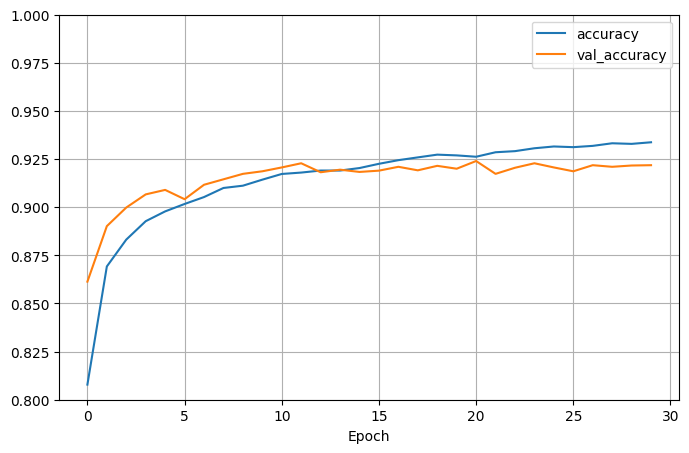

In [39]:
# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

The accuracy of validation set fluctuated since epoch = 12, thus, we set the epochs = 12.

## 4. Final models

### 4.1 K-nearest neighbors

Best paras for K-nearest neighbors is:  
'n_neighbors'= 3, 'p'= 1, 'weights'= 'distance'.

In [48]:
# Set the best paras
knn_best_paras = dict({'n_neighbors': 3, 'p': 1, 'weights': 'distance'})

knn = KNeighborsClassifier(**knn_best_paras)
knn_runtime = time.time()
knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
knn_runtime = time.time() - knn_runtime

In [49]:
# Running in around 120s

# Performance on test set.
print(f"KNN training time: {knn_runtime:.2f} s")
print(f"KNN score on the test set: {knn.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}")

KNN training time: 0.07 s
KNN score on the test set: 0.8597


### 4.2 Fully connected neural network

We settled the size of layers (784, 100, 20, 10) in section 2.2; and settled the the best paras of our experimental settings:   
'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.001   
epochs: 10

In [7]:
# Running in around 25s

keras.backend.clear_session()

# Set Random seed to 0
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# Build the final model
mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=IMAGE_SIZE),
    keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    keras.layers.Dense(20, activation="relu", kernel_initializer=initializer),
    keras.layers.Dense(10, activation="softmax", kernel_initializer=initializer)
])

mlp.summary()

# Complie the model
mlp.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
mlp_runtime = time.time()
mlp.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=1)
mlp_runtime = time.time() - mlp_runtime

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 80,730
Trainable params: 80,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5446 - accuracy: 0.8088 - val_loss: 0.4020 - val_accuracy: 0.8557
Epoch 2/10
1688/1688 [==================

In [8]:
# Performance on test set.
loss, accuracy = mlp.evaluate(X_test, y_test)
print(f"MLP training time: {mlp_runtime:.2f} s")
print(f"MLP score on the test set: {accuracy:.4f}")


313/313 [==============================] - 0s 1ms/step - loss: 0.3339 - accuracy: 0.8852
MLP training time: 22.48 s
MLP score on the test set: 0.8852


### 4.3 Convolutional neural network

We designed a proper architecture of CNN in section 2.3; and settled the the best paras of our experimental settings:   
'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)  
epochs: 12

In [11]:
# Running in around 200s

keras.backend.clear_session()

# Set Random seed to 0
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# Build the final model
cnn = keras.Sequential([
        # Specify the input shape
        keras.Input(shape=(*IMAGE_SIZE, 1)),
        
        # Conv and pool block 1
        keras.layers.Conv2D(
            32, 
            kernel_size=(3, 3), 
            activation="relu", 
            strides=(1, 1),
            kernel_initializer=initializer
            ),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
        
        # Conv and pool block 2
        keras.layers.Conv2D(
            64, 
            kernel_size=(3, 3), 
            activation="relu", 
            strides=(1, 1),
            kernel_initializer=initializer
            ),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
        
        # Flatten and classify using dense output layer
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(class_names), activation="softmax", kernel_initializer=initializer),
    ])

cnn.summary()

# Complie the model
cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
cnn_runtime = time.time()
cnn.fit(np.expand_dims(X_train, -1), y_train, epochs=12, validation_data=(np.expand_dims(X_valid, -1), y_valid), verbose=1)
cnn_runtime = time.time() - cnn_runtime

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0

In [12]:
# Performance on test set.
loss, accuracy = cnn.evaluate(np.expand_dims(X_test, -1), y_test)
print(f"CNN training time: {cnn_runtime:.2f} s")
print(f"CNN score on the test set: {accuracy:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.2414 - accuracy: 0.9126
CNN training time: 198.46 s
CNN score on the test set: 0.9126


Finalized at 10/12 1:30